#Time Series Analysis
@Yu-Wei Hsu

## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.api as sm
import itertools
from sklearn.metrics import mean_squared_error, r2_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Set the graph size and style
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (24,8)

## Acquire data

In [ ]:
# Acquire the data from spread sheet
path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRUZSp-n5HHxBy8GW-vtS94mH9zEJD9DcCNOvk17qr42PYNUGB3ghjLeBetdq4lvzI26EZ7kSIjvVob/pub?gid=1546460073&single=true&output=csv"
df = pd.read_csv(path,index_col="Row ID")

# Print out the sahpe of the data and first five rows of the data
print("Shape of the data: ", df.shape)
print()
df.head(5)

Shape of the data:  (9800, 17)



,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Row ID,,,,,,,,,,,,,,,,,
1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [ ]:
# Check the data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9800 entries, 1 to 9800
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9800 non-null   object 
 1   Order Date     9800 non-null   object 
 2   Ship Date      9800 non-null   object 
 3   Ship Mode      9800 non-null   object 
 4   Customer ID    9800 non-null   object 
 5   Customer Name  9800 non-null   object 
 6   Segment        9800 non-null   object 
 7   Country        9800 non-null   object 
 8   City           9800 non-null   object 
 9   State          9800 non-null   object 
 10  Postal Code    9789 non-null   float64
 11  Region         9800 non-null   object 
 12  Product ID     9800 non-null   object 
 13  Category       9800 non-null   object 
 14  Sub-Category   9800 non-null   object 
 15  Product Name   9800 non-null   object 
 16  Sales          9800 non-null   float64
dtypes: float64(2), object(15)
memory usage: 1.3+ MB


- Choose only "Order Date" and "Sales" to fit in time series analysis.
- The data type of "Order Date" is an object, which should be converted to the DateTime data type.

In [ ]:
# Filter out only Order Date and Sales columns
df_trimmed = df[['Order Date','Sales']]

# Convert the data type of Order Date to Datetime
df_trimmed['Order Date'] = pd.to_datetime(df_trimmed['Order Date'], format = '%d/%m/%Y')

# Set the index as Order Date
df_trimmed.set_index('Order Date',inplace = True)

# Sort the data by Order Date
df_trimmed.sort_index(inplace = True)

#df_trimmed.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


### Check missing values

In [ ]:
# Check if there is na value
#df_trimmed['Sales'].isna()

In [ ]:
# fill linear data in missing values
#df_trimmed['Sales'].interpolate()

## ADF

In [ ]:
# Create new dataframe to store average of Sales group by month
temp = df_trimmed['Sales']
temp = pd.DataFrame(temp)
temp_m = temp.resample('M').mean()
df_month = temp_m.copy()

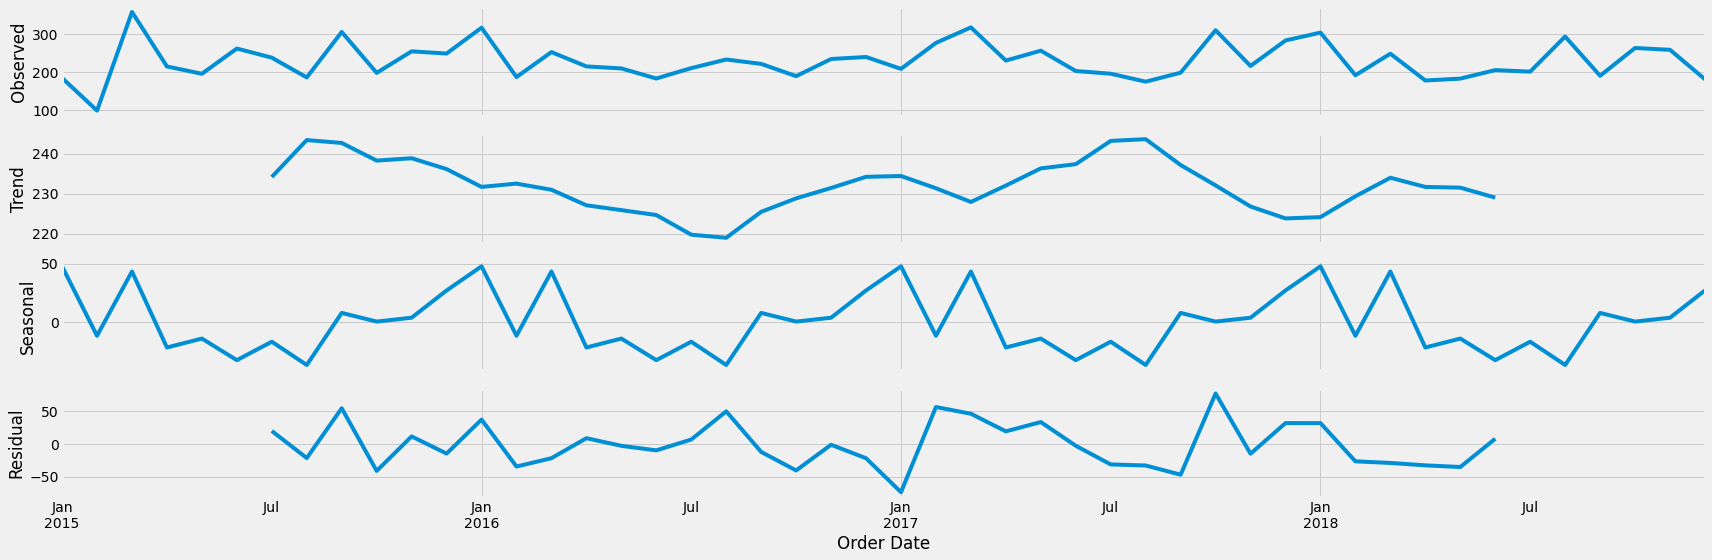

In [ ]:
# Plot of decompose Sales (Trend, Seasonal, and Risidual)
decomposition = sm.tsa.seasonal_decompose(df_month.Sales, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
# ADF of Sales (original data)
adf = adfuller(df_month.Sales,autolag='AIC') 

# Print the result of ADF
print('ADF statistic: %f' % adf[0])
print('p-value: %f' % adf[1])
print("Critical values :")
for k, v in adf[4].items():
    print("\t{}: {} - The data {} stationary with {}% confidence".format(k, v, "is" if adf[0]<v else "is not", 100-int(k[:-1])))
 

ADF statistic: -3.257723
p-value: 0.016877
Critical values :
	1%: -3.6209175221605827 - The data is not stationary with 99% confidence
	5%: -2.9435394610388332 - The data is stationary with 95% confidence
	10%: -2.6104002410518627 - The data is stationary with 90% confidence


### Trasformed Sales
- First Differenced
- Seasonal Differenced
- De-trended

In [ ]:
# Differenced Sales
df_month['Sales_1d'] = df_month['Sales'].diff()

# Seasonal Differenced Sales
df_month['Sales_sd'] = df_month['Sales'] - df_month['Sales'].shift(12)

# de-trended Sales
df_month['z_Sales'] = (df_month['Sales'] - df_month.Sales.rolling(window=12).mean()) / df_month.Sales.rolling(window=12).std()

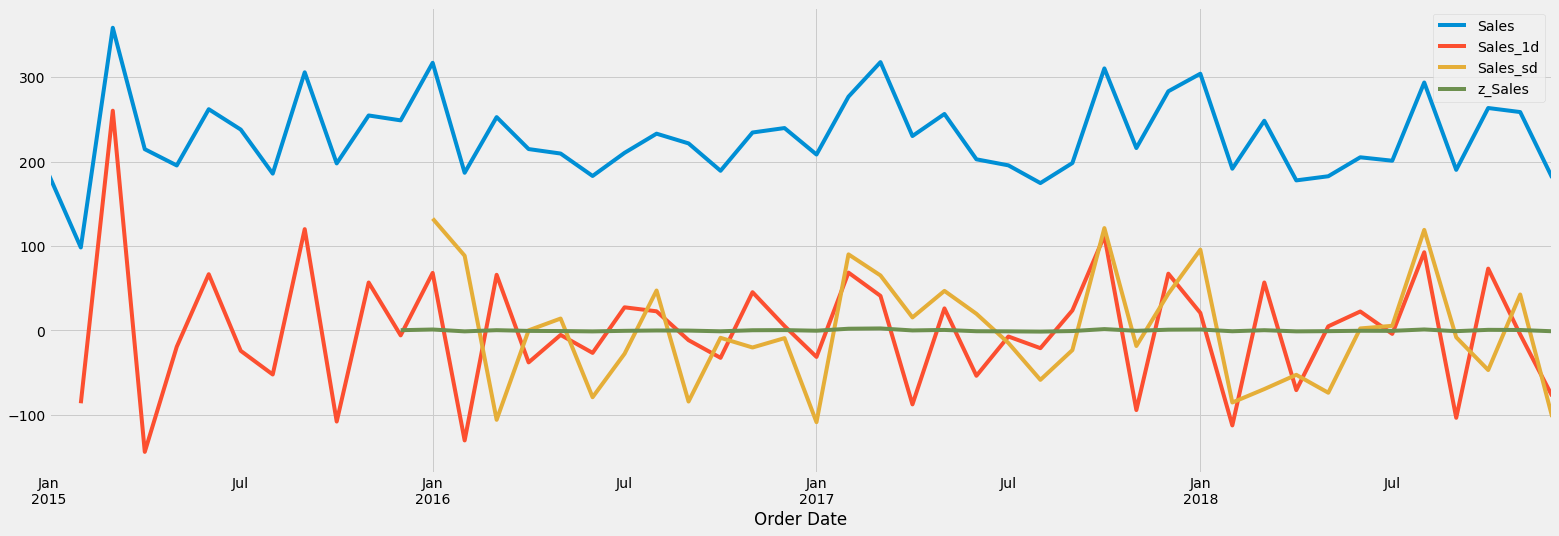

In [ ]:
# Plot for orginal Sales and transformed Sales
ax = df_month.plot()
plt.show()

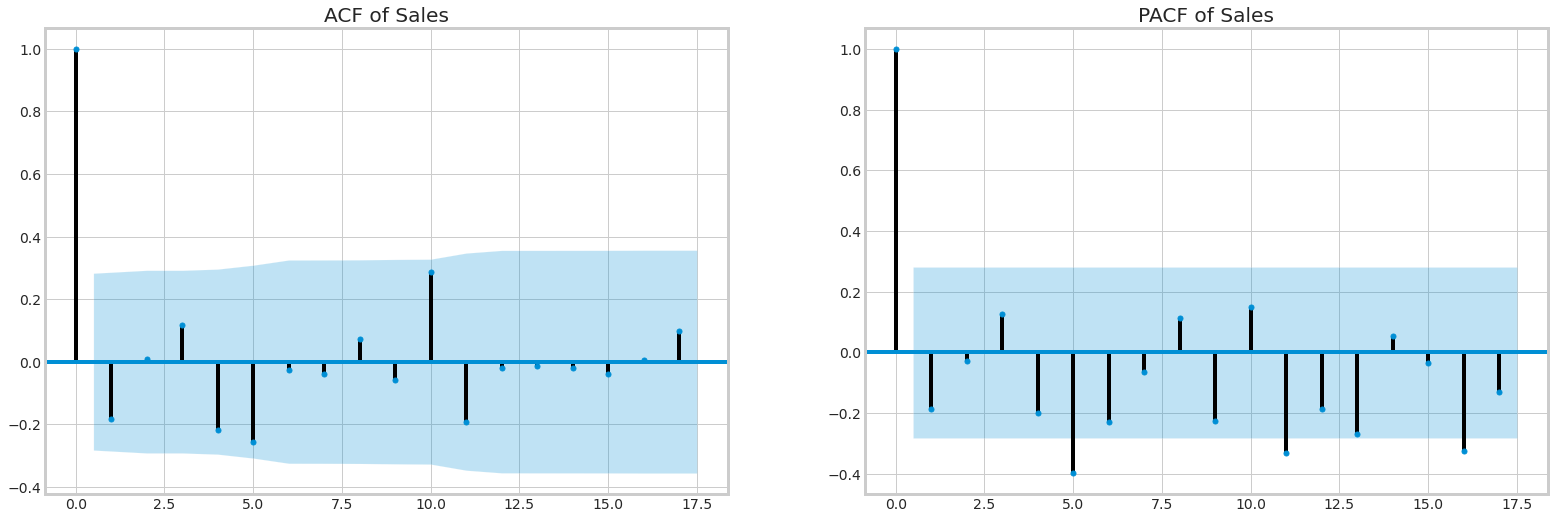

In [ ]:
# ACF and PACF of differenced and de-trended data
sns.set_style('whitegrid')
f, ax = plt.subplots(1,2)
ax[0] = plot_acf(df_month.Sales,title = 'ACF of Sales',ax= ax[0])
ax[1] = plot_pacf(df_month.Sales,title = 'PACF of Sales',ax= ax[1])
plt.show()

 -  Both ACF and PACF of original Sales show a sin curve with a strong correlation at initial lags; thus, AR(p) and MA(q) both affect the time series signal.


## ARMA

 - Since p and q are affecting the time series, let's first try AR(1) and MA(1) for the ARMA model.

In [ ]:
# Find the best pdq combination from lowest AIC for ARIMA model 

# Create combinations of pdq
p  = q = range(0, 3) 
pq = list(itertools.product(p, q))

# Create dataframe for pdq and aic 
model_output = pd.DataFrame(columns = ['parameters', 'results.aic'])

# Fit the combinations of pdq in ARIMA model
for parameters in pq:
    try:
        mod = ARMA(df_month.Sales,order=parameters)
        results = mod.fit()
        model_output = model_output.append({'parameters': 'ARMA{}'.format(parameters),
                                            'results.aic': '{}'.format(results.aic)}, ignore_index = True)
    except:
          pass

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


In [ ]:
# See the best three combination of pq for ARMA model
model_output.sort_values('results.aic').head(3)

,parameters,results.aic
4,"ARMA(1, 1)",509.3195559914648
0,"ARMA(0, 0)",513.0858488839019
1,"ARMA(0, 1)",513.403903043368


In [ ]:
mod = ARMA(df_month.Sales,order=(1,1))
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   48
Model:                     ARMA(1, 1)   Log Likelihood                -250.660
Method:                       css-mle   S.D. of innovations             43.688
Date:                Wed, 17 Feb 2021   AIC                            509.320
Time:                        00:11:54   BIC                            516.804
Sample:                    01-31-2015   HQIC                           512.148
                         - 12-31-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         230.8722      1.069    215.872      0.000     228.776     232.968
ar.L1.Sales     0.6213      0.121      5.129      0.000       0.384       0.859
ma.L1.Sales    -1.0000      0.054    -18.410      0.000      -1.106      -0.894
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6095           +0.0000j            1.6095            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

- By fitting AR(1) and MA(1) in the ARMA model, we got:
  -  Both p-values of AR(p) and MA(q) are lower than 0.05
  -  AIC is 509.32

### ARIMA

In [ ]:
# Find the best pdq combination from lowest AIC for ARIMA model 

# Create combinations of pdq
p = d = q = range(0, 3) 
pdq = list(itertools.product(p, d, q))

# Create dataframe for pdq and aic 
model_output = pd.DataFrame(columns = ['parameters', 'results.aic'])

# Fit the combinations of pdq in ARIMA model
for parameters in pdq:
    try:
        mod = ARIMA(df_month.Sales,order=parameters)
        results = mod.fit()
        model_output = model_output.append({'parameters': 'ARIMA{}'.format(parameters),
                                            'results.aic': '{}'.format(results.aic)}, ignore_index = True)
    except:
          pass


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


In [ ]:
# See the best three combination of pdq for ARIMA model
model_output.sort_values(by = 'results.aic').head(3)

,parameters,results.aic
8,"ARIMA(1, 0, 1)",509.3195559914648
4,"ARIMA(0, 1, 1)",509.33549312988663
10,"ARIMA(1, 1, 1)",510.0266556883159


In [ ]:
# Fit the best pdq for ARIMA and print out the summary
mod = ARIMA(df_month.Sales,order=(1, 0, 1))
result = mod.fit()
print(result.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                   48
Model:                     ARMA(1, 1)   Log Likelihood                -250.660
Method:                       css-mle   S.D. of innovations             43.688
Date:                Wed, 17 Feb 2021   AIC                            509.320
Time:                        00:11:56   BIC                            516.804
Sample:                    01-31-2015   HQIC                           512.148
                         - 12-31-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         230.8722      1.069    215.872      0.000     228.776     232.968
ar.L1.Sales     0.6213      0.121      5.129      0.000       0.384       0.859
ma.L1.Sales    -1.0000      0.054    -18.410    

- After running a loop to find the combination of best values for parameters p, d, and q. We got (1,0,1), which is the same function as ARMA when we put 0 in d.


### Forecast

In [ ]:
# Split test and train data
train = df_month.Sales[:-5]
test = df_month.Sales[-6:]

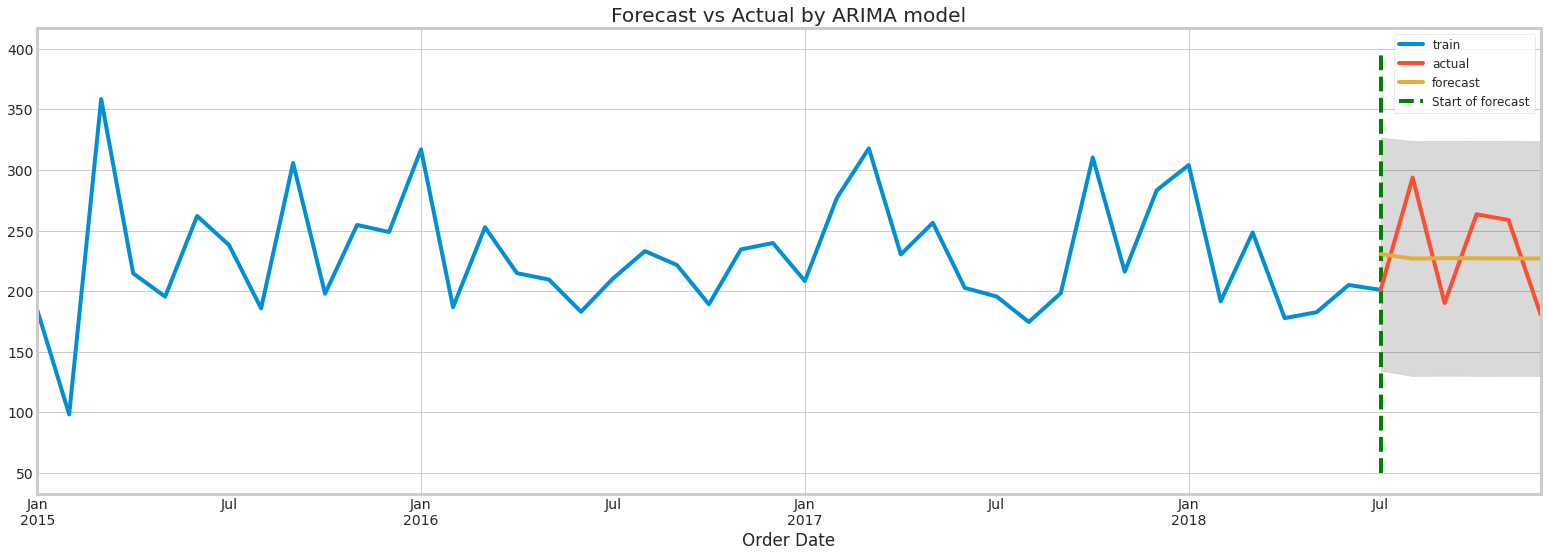

In [ ]:
# Fit train dataset in ARIMA(1,0,1) model
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(6, alpha=0.05)

# Make as series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
f,ax = plt.subplots()
ax = train.plot(label='train')
ax = test.plot(label='actual')
ax = fc_series.plot(label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
ax.vlines('2018-07', 50, 400, linestyle='--', color='g', label='Start of forecast')
plt.title('Forecast vs Actual by ARIMA model')
plt.legend(loc='upper right', fontsize=12)
plt.show()

In [ ]:
# Print MSE, RMSE, and MAPE
print('MSE:',mean_squared_error(test,fc))
print('RMSE:',np.sqrt(mean_squared_error(test,fc)))
print('MAPE:',np.mean(np.abs(fc-test)/np.abs(test)))


MSE: 1857.5070724000554
RMSE: 43.09880592777549
MAPE: 0.18062921584450595


- We got 18.06% MAPE implies the model is about 81.94% accurate in predicting the next six months.

###Forecast (Out of Sample)

In [ ]:
# Get the next five months forecast(mean of Sales and range of 95% confident interval)
pred = result.forecast(steps=5,alpha=0.05,exog=None)

# Create next five months index
five = ['2019-01-31','2019-02-28','2019-03-31','2019-04-30','2019-05-31']
fc_mon = pd.to_datetime(five,format='%Y/%m/%d')

# Create dataframe for Date and forecast of next five month
pred_df = pd.DataFrame({'Order Date':fc_mon,'Sales':pred[0]})
pred_df.set_index('Order Date',inplace=True)

# Combine original Sales and predicted Sales
df_comb= pd.concat([pd.DataFrame(df_month.Sales),pred_df])

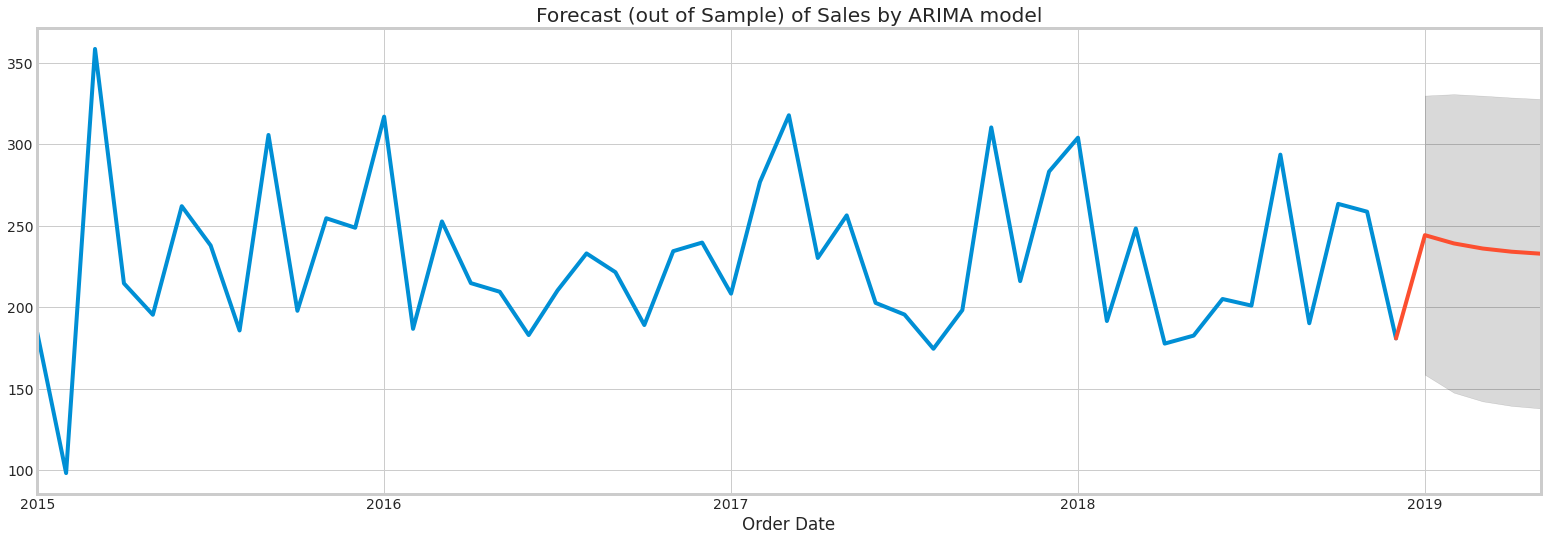

In [ ]:
# Plot out of sample forecast for next five months
fig, ax = plt.subplots()
ax = df_comb[:-5].Sales.plot()
ax = df_comb[-6:].Sales.plot()

# Confident Interval
ax.fill_between(df_comb[-5:].index,
                pd.DataFrame(pred[2]).iloc[:,0],
                pd.DataFrame(pred[2]).iloc[:,1], color='k', alpha=.15)
plt.title('Forecast (out of Sample) of Sales by ARIMA model')
plt.show()

## SARIMAX

In [ ]:
# Find the best pdq combination from lowest AIC for SARIMAX model

# Create combinations of pdq and seasonal parameters
p = d = q = range(0, 2) 
pdq = list(itertools.product(p, d, q))
pdq_comb = [(i[0], i[1], i[2], 12) for i in list(itertools.product(p, d, q))]

# Create dataframe for parameters and aic 
models_output = pd.DataFrame(columns = ['parameters', 'results.aic'])

# Fit the combinations in SARIMAX model
for param in pdq:
    for param_seasonal in pdq_comb:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_month.Sales,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            models_output = models_output.append({'parameters': 'SARIMAX{}x{}12'.format(param, param_seasonal),
                                                'results.aic': results.aic}, ignore_index = True)
        except:
            continue


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

In [ ]:
# See the best three combinations for SARIMAX model
models_output.sort_values(by = 'results.aic').head(3)

,parameters,results.aic
47,"SARIMAX(1, 1, 1)x(1, 1, 0, 12)12",244.991154
41,"SARIMAX(1, 1, 0)x(1, 1, 0, 12)12",247.966417
29,"SARIMAX(1, 0, 0)x(1, 1, 0, 12)12",254.596828


- After running the loop to find the combination of best values for parameters, we got (1,1,1)X(1,1,0,12) for the lowest AIC.

In [ ]:
# Fit the best combination for SARIMAX and print out the summary
mod = sm.tsa.statespace.SARIMAX(df_month.Sales,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False) #model defintion
results = mod.fit() 
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -118.496
Date:                            Wed, 17 Feb 2021   AIC                            244.991
Time:                                    00:12:02   BIC                            249.355
Sample:                                01-31-2015   HQIC                           246.019
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0997      0.250     -0.399      0.690      -0.590       0.390
ma.L1         -1.0000   1169.638   

- However, after fitting in the SARIMAX model, p-values are higher than 0.05, which means the coefficients are insignificant.
- AIC: 244.991

In [ ]:
# Fit the best combination for SARIMAX and print out the summary
mod = sm.tsa.statespace.SARIMAX(df_month.Sales,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0 , 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False) #model defintion
result110 = mod.fit() 
print(result110.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -120.983
Date:                            Wed, 17 Feb 2021   AIC                            247.966
Time:                                    00:12:02   BIC                            251.240
Sample:                                01-31-2015   HQIC                           248.737
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6193      0.209     -2.957      0.003      -1.030      -0.209
ar.S.L12      -0.6301      0.216   

- After trying the combination of (1,1,0) x (1,1,0,12), the p-values are lower than 0.05, which means that the coefficient is highly significant.
- AIC: 247.966

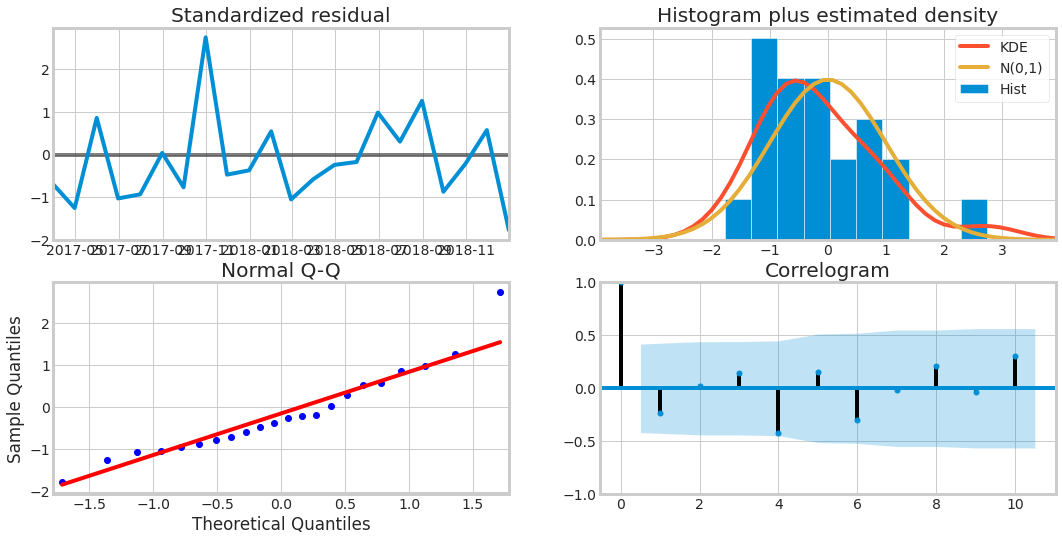

In [ ]:
# Plot the diagnostic graphs
result110.plot_diagnostics(figsize=(16, 8))
plt.show()

### Forecast

In [ ]:
# Predict dynamic from SARIMAX model
pred_dynamic = result110.get_prediction(start=pd.to_datetime('2018-07-31'), dynamic=True, full_results=True)

# Get Confindent Interval
pred_dynamic_ci = pred_dynamic.conf_int()

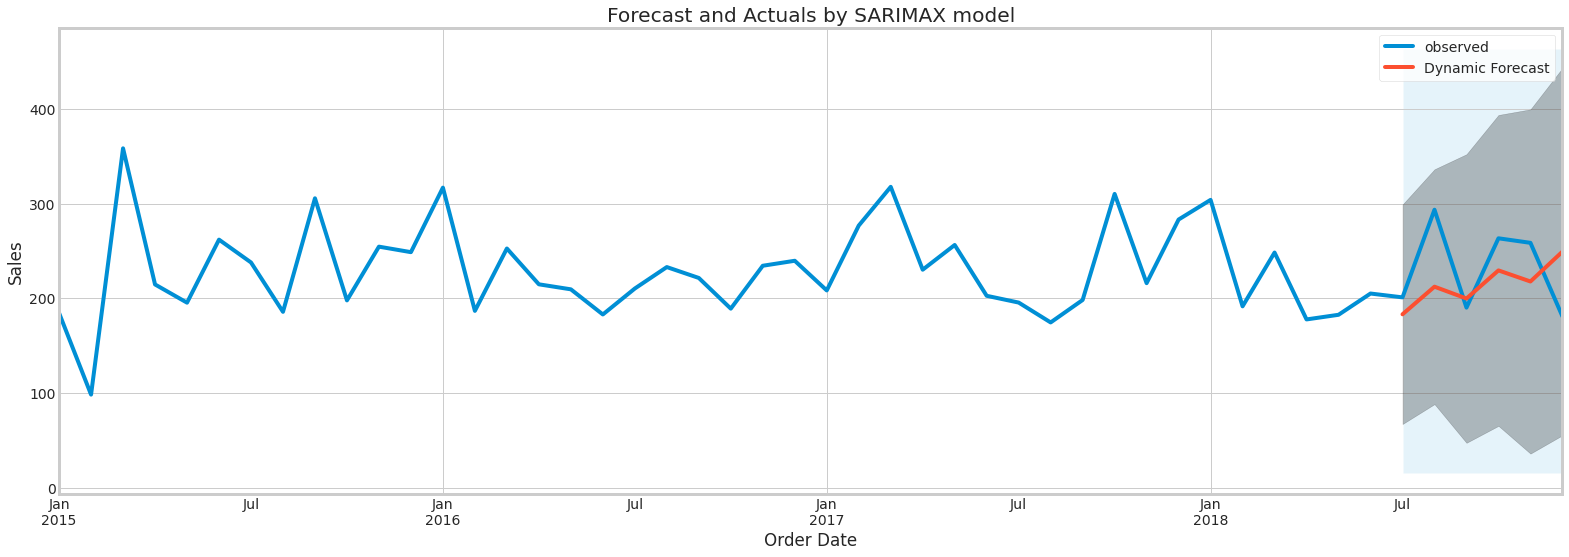

In [ ]:
#Plot the forecast of last six months
ax = df_month.Sales.plot(label='observed')
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-07-31'), df_month.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Order Date')
ax.set_ylabel('Sales')
plt.title('Forecast and Actuals by SARIMAX model')
plt.legend()

In [ ]:
# Prediction
y_fc = pred_dynamic.predicted_mean

# Print MSE, RMSE, and MAPE
print('MSE:',mean_squared_error(test,y_fc))
print('RMSE:',np.sqrt(mean_squared_error(test,y_fc)))
print('MAPE:',np.mean(np.abs(y_fc-test)/np.abs(test)))


MSE: 2421.531186252703
RMSE: 49.209055937425816
MAPE: 0.18024894736852723


- Compared to the ARIMA(1,0,1) model
 - MSE: 1857.5070724000554
 - RMSE: 43.09880592777549
 - MAPE: 0.18062921584450595

- The MSE and RMSE are higher in the SARIMAX model.
- However, the MAPE is lower in SARIMAX around 0.02%. We got about 81.98% accurate in predicting the next six months.



### Forecast (Out of Sample)

In [ ]:
# Get forecasts
pred_uc = result110.get_forecast(steps=6)

# Get confidence intervals
pred_ci = pred_uc.conf_int()

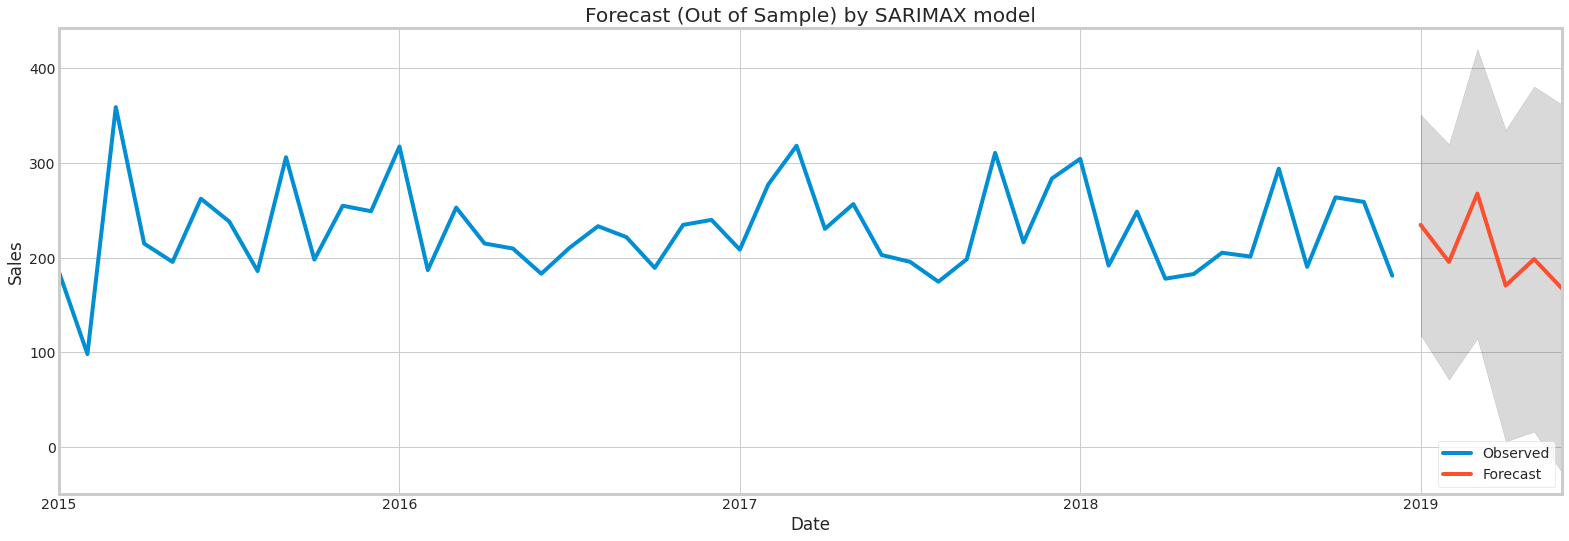

In [ ]:
# Plot forecasts(out of sample) of next six month
ax = df_month.Sales.plot(label='Observed')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
# Confident Interval
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.15)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Forecast (Out of Sample) by SARIMAX model')
plt.legend(loc = 'lower right')
plt.show()

### Summary
- For this Sales dataset, we selected Order Date and Sales to do time series analysis. After trying different combinations of pdq parameters in the ARIMA model, we got (1,0,1) with the lowest AIC, which functions as the ARMA model with (1,1) parameter.
- We got 509.320 of AIC in the ARIMA model and 81.96% accuracy for the next six months forecasting. Also lower AIC of 247.966 in SARIMAX (1,1,0)x(1,1,0,12) model, and 81.98% of accuracy for next six months prediction.
- This dataset records from January 2015 to December 2018 with four years of Sales. We could use more records to get better accuracy and a longer period of future forecasts.




### Reference
- Kaggle Dataset
https://www.kaggle.com/rohitsahoo/sales-forecasting
- Selva Prabhakaran. ARIMA Model – Complete Guide to Time Series Forecasting in Python.
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
- Pandas. Working with missing data.
https://pandas.pydata.org/pandas-docs/version/0.12.0/missing_data.html
- PRABHAT9. (OCT 29, 2020). How to Create an ARIMA Model for Time Series Forecasting in Python.
https://www.analyticsvidhya.com/blog/2020/10/how-to-create-an-arima-model-for-time-series-forecasting-in-python/
- Pandas. Merge, join, concatenate and compare
https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html


